# Cola Bottle Identification

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import os
import cv2
import random
from shutil import copyfile
from glob import glob
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from math import ceil
from scipy import stats
import pandas as pd

## About dataset
Dataset was downloaded from: https://www.kaggle.com/deadskull7/cola-bottle-identification


In [2]:
images_for_comparing_similarities_dir = "images_for_comparing_similarities"
files_from_images_for_comparing_similarities_dir = os.listdir(images_for_comparing_similarities_dir)
path_to_images_that_represent_dataset = [os.path.join(images_for_comparing_similarities_dir,image) for image in files_from_images_for_comparing_similarities_dir]
image_titles = ["m_beer", "md_diet", "md_orig", "p_cheery", "p_diet", "p_orig", "p_sugar", "p_zero"]

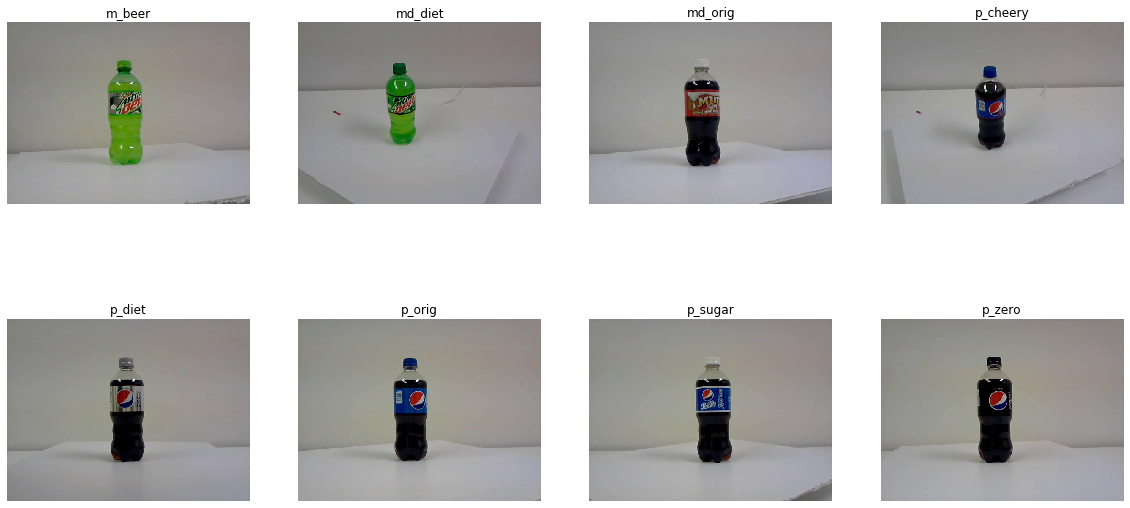

In [3]:
fig=plt.gcf()
rows_number = 2
columns_number = 4
fig=plt.gcf()
fig.set_size_inches(columns_number*5,rows_number*5)
for i, image_path in enumerate(path_to_images_that_represent_dataset):
    sp=plt.subplot(rows_number, columns_number, i+1)
    sp.axis()
    sp.axis('Off')
    image = mpimg.imread(image_path)
    plt.title(image_titles[i])
    plt.imshow(image)
plt.show()

### About dataset - similiratiries and differences between pictures of particular classes that are somewhat similar and how it can impact accuracy of model

* **m_beer** and **md_diet** - only signifact difference is between bottle plug - *m_beer plug* is light compared to *md_diet* plug. So, if there is given photo of *m_beer*, but given input photo is darker, because of that it is more similar to *md_diet*, then prediction would probably be false - it will be predicted that given photo is *md_diet*.
* **md_orig** and **p_sugar** - only signifact difference is between etiquette, but both plugs are white. As there is big difference in etiquette, then that probably won't be problematic.
* **p_cherry** and **p_orig** - only signifact difference is between etiquette - in *p_cherry* there is cherry. If on photo isn't visible cherry, but given input photo is *p_cherry*, then it's a lot harder that given photo would be classified as *p_cheery*.
* **p_orig**, **p_cherry** and **p_zero** - *p_zero* is darker compared to *p_orig* and *p_cherry*, also difference between those 3 are that *p_zero* has *black plug*. If given input photo would be more darker, cherry wouldn't be present, then prediction could be *p_orig* or *p_cherry*

### Data cleaning

**Data cleaning** is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. If data is incorrect, outcomes and algorithms are unreliable, even though they may look correct.

* **Data correctness** - Using manual inspection it is established that **labelling** is correct - there isn't a case that particular image of particular class is placed in wrong directory. 
* **Data corruption** - With regards to **data corruption**, we can check whether we can access photo with Python code - as it was possible to access every photo manually, then probably there won't be problem with loading photo with Python code.
* **Data format** - it should be a case that every photo is in format for image file
* **Data duplication** - We have to check whether there is photos that are identical
* **Data completeness** - Checking whether data isn't skewed - there isn't a case where particular class(es) is/are in extremly small amount 

In [4]:
# DATA AND FORMAT CORRUPTION CHECK
dataset_folder = "dataset"
directories_within_dataset_directory = os.listdir("dataset")
for directory in directories_within_dataset_directory:
    files_inside_directory = os.listdir(os.path.join(dataset_folder, directory))
    for file in files_inside_directory:
        if file.endswith('.jpg'):
            path_to_file = os.path.join(dataset_folder, directory, file)
            try:
                img=Image.open(path_to_file)
                img.verify()
            except(IOError,SyntaxError)as e:
                 print('Corrupted file  :  ' + filename)
        else:
            print("File doesn't have .jpg format")

In [5]:
directories_within_dataset_directory

['M.Beer',
 'MD.Diet',
 'MD.Orig',
 'P.Cherry',
 'P.diet',
 'P.Orig',
 'P.Rsugar',
 'P.Zero']

In [6]:
def get_duplicates(list_of_files):
    dictionary_of_files = {}
    seen = set()
    seen2 = set()
    seen_add = seen.add
    seen2_add = seen2.add
    for index, file in enumerate(list_of_files):
        if file in seen:
            if file in dictionary_of_files:
                dictionary_of_files[file].append(index)                
            else:
                dictionary_of_files[file] = []
                dictionary_of_files[file].append(list_of_files.index(file))
                dictionary_of_files[file].append(index)
            seen2_add(file)
        else:
            seen_add(file)
    return dictionary_of_files

In [7]:
# DATA DUPLICATON - check whether there are photos that are identical in same folder 
# As manually it was seen that there isn't a case that particular photo is placed in wrong folder, then we will check for duplication is same folder where is photo located
number_of_duplicates_per_directory = [0] * 8
counter = 0
for directory in directories_within_dataset_directory:
    files_inside_directory = os.listdir(os.path.join(dataset_folder, directory))
    sizes_of_file = [os.path.getsize(os.path.join(dataset_folder, directory, file)) for file in files_inside_directory]
    duplicates = get_duplicates(sizes_of_file)
    for file_size, indices in duplicates.items():
        for i, file_index in enumerate(indices):
            path_to_current_file = os.path.join(dataset_folder, directory, files_inside_directory[file_index])
            image1 = cv2.imread(path_to_current_file)
            indices_of_other_files_same_size = indices[i+1:len(indices)]
            for index_of_other_files_same_size in indices_of_other_files_same_size:
                path_to_other_file = os.path.join(dataset_folder, directory, files_inside_directory[index_of_other_files_same_size])
                image2 = cv2.imread(path_to_other_file)
                difference = cv2.subtract(image1, image2)
                b, g, r = cv2.split(difference)
                if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
                    number_of_duplicates_per_directory[counter] += 1
                    print("Image: " + files_inside_directory[file_index] + " is identical to image " + files_inside_directory[index_of_other_files_same_size])
    print("Number of duplicates in directory " + directories_within_dataset_directory[counter] + " is " + str(number_of_duplicates_per_directory[counter]))
    counter += 1


Number of duplicates in directory M.Beer is 0
Number of duplicates in directory MD.Diet is 0
Number of duplicates in directory MD.Orig is 0
Number of duplicates in directory P.Cherry is 0
Number of duplicates in directory P.diet is 0
Number of duplicates in directory P.Orig is 0
Number of duplicates in directory P.Rsugar is 0
Number of duplicates in directory P.Zero is 0


## Creating dataset for training, validation and testing

In [ ]:
# creating directory dataset_for_tvt and subdirectories training validation and testing
try:
    os.mkdir('dataset_for_tvt')
    os.mkdir('dataset_for_tvt/training')
    os.mkdir('dataset_for_tvt/validation')
    os.mkdir('dataset_for_tvt/testing')
except OSError:
    pass

In [ ]:
# within folders train validation and test create folder for each class
for directory in directories_within_dataset_directory:
    folder_for_training = os.path.join("dataset_for_tvt", "training", directory)
    folder_for_validation = os.path.join("dataset_for_tvt", "validation", directory)
    folder_for_testing = os.path.join("dataset_for_tvt", "testing", directory)
    os.mkdir(folder_for_training)
    os.mkdir(folder_for_validation)
    os.mkdir(folder_for_testing)

In [ ]:
number_of_dataset_examples = 0
for directory in directories_within_dataset_directory:
    print("Number of images in " + "dataset/"+directory + " = " + str(len(glob("dataset/"+directory +'*/*'))))
    number_of_dataset_examples += len(glob("dataset/"+directory +'*/*'))
print("Total number of dataset examples is: " + str(number_of_dataset_examples))

In [371]:
source_directories = ["dataset/M.Beer/", "dataset/MD.Diet/", "dataset/MD.Orig/", "dataset/P.Cherry/", "dataset/P.diet/", "dataset/P.Orig/", "dataset/P.Rsugar/", "dataset/P.Zero/"]

In [372]:
dataset_for_tvt = "dataset_for_tvt"

In [373]:
def split_data(DIR):
    # DIR is the name of class folder
    # DATASET is splitted 40% in training 20% in validation and 40% test due to using paired ttest 5x2 cross validation
    files = []
    DIR_SOURCE = "dataset"
    DIR_FOR_TVT = "dataset_for_tvt"
    SOURCE_PATH = os.path.join(DIR_SOURCE, DIR)
    TRAIN_DIR = os.path.join(DIR_FOR_TVT, "training", DIR)
    VALIDATION_DIR = os.path.join(DIR_FOR_TVT, "validation", DIR)
    TESTING_DIR = os.path.join(DIR_FOR_TVT, "testing", DIR)
    #TRAINING_DIR = os.path.join(dataset_directory, )
    for filename in os.listdir(SOURCE_PATH):
        file = os.path.join(SOURCE_PATH, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[: ceil(len(shuffled_set) * 0.4)]
    validation_set = shuffled_set[len(training_set): len(training_set) + int(len(shuffled_set) * 0.2)]
    testing_set = shuffled_set[len(training_set) + len(validation_set):len(shuffled_set)]
    for filename in training_set:
        file = os.path.join(SOURCE_PATH, filename)
        destination = os.path.join(TRAIN_DIR, filename)
        copyfile(file, destination)
    for filename in validation_set:
        file = os.path.join(SOURCE_PATH, filename)
        destination = os.path.join(VALIDATION_DIR, filename)
        copyfile(file, destination)
    for filename in testing_set:
        file = os.path.join(SOURCE_PATH, filename)
        destination = os.path.join(TESTING_DIR, filename)
        copyfile(file, destination)
    #print("training_length " + str(training_length))
    #print("validation_length " + str(validation_length))
    #print("test_length " + str(test_length))
    #print("sum of tvt " + str(len(training_set) + len(validation_set) + len(testing_set)))

In [374]:
# CREATE DATASET FOR TENSORFLOW
for directory in directories_within_dataset_directory:
    split_data(directory)

In [375]:
dataset_for_tvt = "dataset_for_tvt"
train_dir = os.path.join(dataset_for_tvt,'training/')
validation_dir = os.path.join(dataset_for_tvt,'validation/')
testing_dir = os.path.join(dataset_for_tvt,'testing/')

In [376]:
print('Number of images in training set = ',str(len(glob(train_dir+'*/*'))))
print('Number of images in validation set = ',str(len(glob(validation_dir+'*/*'))))
print('Number of images in testing set = ',str(len(glob(testing_dir+'*/*'))))
print("Total number of dataset examples is: " + str(len(glob(train_dir+'*/*')) + len(glob(validation_dir+'*/*')) + len(glob(testing_dir+'*/*'))))

Number of images in training set =  2648
Number of images in validation set =  1320
Number of images in testing set =  2647
Total number of dataset examples is: 6615


## Creating models and training

In [377]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
print(tf.version.VERSION)

2.3.1


## Custom model

In [4]:
dataset_for_tvt = "dataset_for_tvt"
train_dir = os.path.join(dataset_for_tvt,'training/')
validation_dir = os.path.join(dataset_for_tvt,'validation/')
testing_dir = os.path.join(dataset_for_tvt,'testing/')

In [415]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
 rotation_range=10,
 width_shift_range=0.1,
 height_shift_range=0.1,
 zoom_range=0.1,
 )
val_datagen=ImageDataGenerator(rescale=1.0/255)
test_datagen=ImageDataGenerator(rescale=1.0/255)

In [416]:
training_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (160, 160),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
)

Found 2647 images belonging to 8 classes.


In [417]:
training_generator.class_indices

{'M.Beer': 0,
 'MD.Diet': 1,
 'MD.Orig': 2,
 'P.Cherry': 3,
 'P.Orig': 4,
 'P.Rsugar': 5,
 'P.Zero': 6,
 'P.diet': 7}

In [418]:
validation_generator = train_datagen.flow_from_directory(
    validation_dir, 
    target_size = (160, 160),
    color_mode = 'rgb',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
)

Found 1320 images belonging to 8 classes.


In [419]:
test_generator=test_datagen.flow_from_directory(
    testing_dir,
    color_mode="rgb", 
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical',
    shuffle = False
)

Found 2648 images belonging to 8 classes.


As we work with images, we will use CNN. In this case sequential model.

* **Conv2D** layers are used to detect particular features, 
* **MaxPooling2D** to reduce image to make training faster,
* **BatchNormalization** to make training smoother and for regularisation,
* **Dropout** for regularisation,
* **Dense** for learning reletionships between detected features,

In [420]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [421]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [422]:
model_checkpoint = ModelCheckpoint('custom_model5.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [423]:
early_stopping = EarlyStopping(
              patience=10,
              min_delta=0.05,
              baseline=None,
              mode="auto",
              monitor='val_accuracy',
              restore_best_weights=True,
              verbose=1)

In [424]:
history=model.fit(training_generator,validation_data=validation_generator,epochs=50,
                  verbose=2, callbacks=[model_checkpoint, early_stopping])

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.12727, saving model to custom_model5.h5
42/42 - 141s - loss: 5.1342 - accuracy: 0.1341 - precision: 0.1223 - recall: 0.0412 - val_loss: 2.0793 - val_accuracy: 0.1273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50

Epoch 00002: val_accuracy did not improve from 0.12727
42/42 - 109s - loss: 2.0029 - accuracy: 0.1927 - precision: 0.4861 - recall: 0.0132 - val_loss: 2.4193 - val_accuracy: 0.1265 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.12727
42/42 - 112s - loss: 1.6368 - accuracy: 0.2951 - precision: 0.5304 - recall: 0.1152 - val_loss: 2.4468 - val_accuracy: 0.1242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.12727
42/42 - 109s - loss: 1.2181 - accuracy: 0.4454 - precision: 0.5458 - recall: 0.2724 - val_loss: 3.3748 - val_accuracy: 0.1273 - val_precision: 0.0000e+00 - val_

In [425]:
evaluation = model.evaluate(test_generator)

42/42 [==============================] - 31s 745ms/step - loss: 0.3136 - accuracy: 0.8637 - precision: 0.8771 - recall: 0.8520


In [426]:
predictions = model.predict(test_generator)

In [427]:
y_true = test_generator.classes
y_pred = np.array([np.argmax(x) for x in predictions])

In [428]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [429]:
cm

array([[314,   1,   1,   1,   0,   0,  12,   7],
       [  0, 323,  12,   0,   0,   0,   1,   0],
       [  0,   0, 338,   0,   0,   0,   0,   0],
       [  0,   0,   0, 283,   1,  32,   2,   0],
       [  0,   0,   0, 211,  92,  17,   0,   0],
       [  0,   0,   0,   6,   0, 312,   9,   3],
       [  0,   0,   0,   0,   0,   3, 324,   3],
       [  0,   0,   0,   0,   0,   0,  39, 301]], dtype=int64)

In [430]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=training_generator.class_indices)

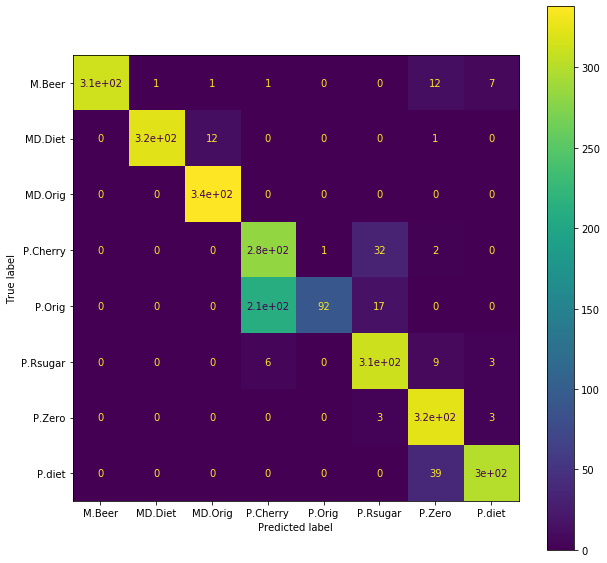

In [431]:
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

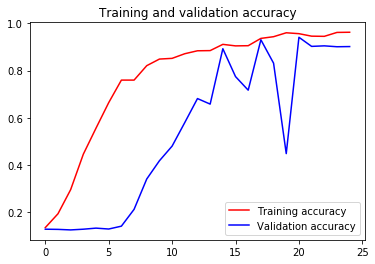

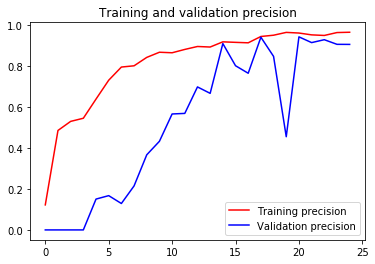

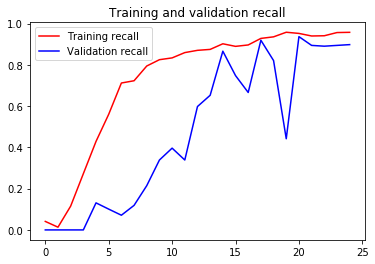

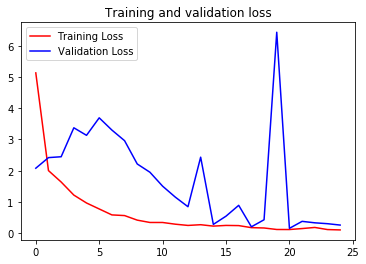

In [432]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## InceptionV3


InceptionV3 is both wide and deep architecture.

It is wide because it uses filter of different size, so it captures information both locally and globally.

It is deep because it uses a lot of convolutional layers which are used to identify complex features.

Previously I had good results with it so I went with it.

In [433]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [434]:
pretrained_model=InceptionV3(input_shape=(160,160,3),
                             include_top=False,
                             weights='imagenet')
for layers in pretrained_model.layers:
    layers.trainable=False

In [435]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_918 (Conv2D)             (None, 79, 79, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_906 (BatchN (None, 79, 79, 32)   96          conv2d_918[0][0]                 
__________________________________________________________________________________________________
activation_846 (Activation)     (None, 79, 79, 32)   0           batch_normalization_906[0][0]    
_______________________________________________________________________________________

In [436]:
last_layer=pretrained_model.get_layer('mixed9_0')  

In [437]:
last_output = last_layer.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model = tf.keras.Model(pretrained_model.input,x)


In [438]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [439]:
model_checkpoint = ModelCheckpoint('inception_v3_model_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(
              patience=10,
              min_delta=0.05,
              baseline=None,
              mode="auto",
              monitor='val_accuracy',
              restore_best_weights=True,
              verbose=1)

In [440]:
history=model.fit(training_generator,validation_data=validation_generator,epochs=50,
                  verbose=2, callbacks=[model_checkpoint, early_stopping])

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.79621, saving model to inception_v3_model_1.h5
42/42 - 106s - loss: 1.0306 - accuracy: 0.6033 - precision: 0.7276 - recall: 0.4934 - val_loss: 0.5186 - val_accuracy: 0.7962 - val_precision: 0.8357 - val_recall: 0.7515
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.79621 to 0.84167, saving model to inception_v3_model_1.h5
42/42 - 94s - loss: 0.5120 - accuracy: 0.7869 - precision: 0.8185 - recall: 0.7563 - val_loss: 0.3723 - val_accuracy: 0.8417 - val_precision: 0.8599 - val_recall: 0.8227
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.84167 to 0.84773, saving model to inception_v3_model_1.h5
42/42 - 88s - loss: 0.4040 - accuracy: 0.8334 - precision: 0.8515 - recall: 0.8100 - val_loss: 0.3494 - val_accuracy: 0.8477 - val_precision: 0.8637 - val_recall: 0.8303
Epoch 4/50

Epoch 00004: val_accuracy improved from 0.84773 to 0.86970, saving model to inception_v3_model_1.h5
42/42 - 85s - loss: 0.3077 - accuracy: 0.873

In [441]:
evaluation = model.evaluate(test_generator)

42/42 [==============================] - 45s 1s/step - loss: 0.2045 - accuracy: 0.9169 - precision: 0.9217 - recall: 0.9158


In [442]:
true_labels = test_generator.classes
predictions = model.predict(test_generator)

In [443]:
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

In [444]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [445]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

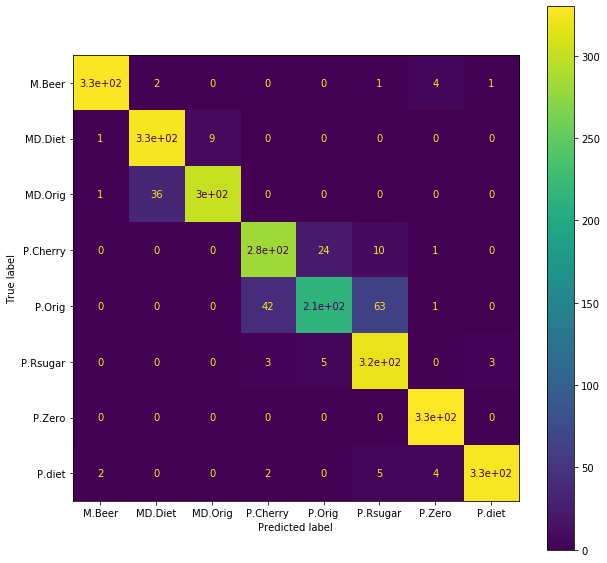

In [446]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=training_generator.class_indices)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

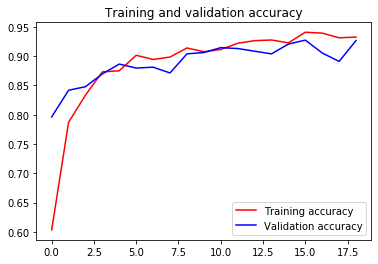

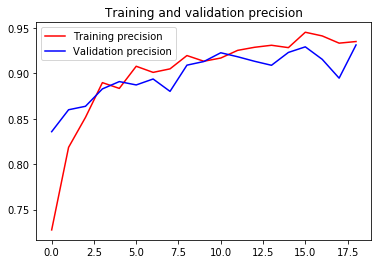

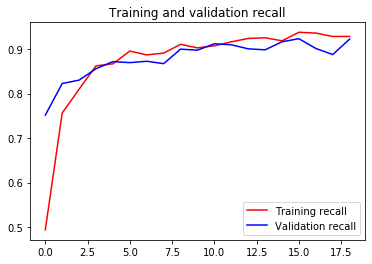

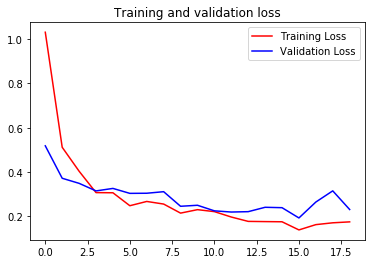

In [447]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [448]:
from sklearn.metrics import classification_report

## Model evaluation

In [452]:
df_custom_model_accuracies = pd.read_excel('custom_model_evaluations.xlsx')
df_inception_model_accuracies = pd.read_excel('inceptionV3_evaluations.xlsx')

In [453]:
print("CUSTOM MODEL ACCURACIES")
print(df_custom_model_accuracies.to_string())

CUSTOM MODEL ACCURACIES
   acc_1  acc_2
0   0.88   0.93
1   0.93   0.80
2   0.96   0.94
3   0.92   0.96
4   0.90   0.86


In [454]:
print("INCEPTION V3 ACCURACIES")
print(df_inception_model_accuracies.to_string())

INCEPTION V3 ACCURACIES
   acc_1  acc_2
0   0.90   0.91
1   0.92   0.92
2   0.88   0.88
3   0.90   0.92
4   0.89   0.92


In [458]:
mean_acc_custom_model = df_custom_model_accuracies["acc_1"].append(df_custom_model_accuracies["acc_2"]).mean(axis=0)
mean_acc_inception_model = df_inception_model_accuracies["acc_1"].append(df_inception_model_accuracies["acc_2"]).mean(axis=0)
print("Custom model mean: " + str(mean_acc_custom_model))
print("Inception model mean: " + str(mean_acc_inception_model))

Custom model mean: 0.9079999999999998
Inception model mean: 0.9040000000000001


**Null hypothesis**: "Difference between mean performance is probably real"

**The alternative hypothesis**: "Algorithms probably have the same performance"

In [459]:
def paired_ttest_5x2cv(df1, df2):
    variance_sum = 0
    first_diff = None
    for i in range(5):
        diff_1 = df1["acc_1"][i] - df2["acc_1"][i]
        diff_2 = df1["acc_2"][i] - df2["acc_2"][i]
        mean = (diff_1 + diff_2) / 2.
        variance = ((diff_1 - mean)**2 +
                    (diff_2 - mean)**2)
        variance_sum += variance
        if first_diff is None:
            first_diff = diff_1
    numerator = first_diff
    denominator = np.sqrt(1/5. * variance_sum)
    t_stat = numerator / denominator
    pvalue = stats.t.sf(np.abs(t_stat), 5)*2.
    return float(t_stat), float(pvalue)

In [460]:
t, p = paired_ttest_5x2cv(df_custom_model_accuracies, df_inception_model_accuracies)

In [461]:
if p <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

Algorithms probably have the same performance
